# Breast Cancer Classification with Neural Networks

This notebook requirements:
- Load and preprocess the Wisconsin Breast Cancer (Diagnostic) dataset
- Perform exploratory data analysis (EDA)
- Build a neural network with ≤ 300 parameters
- Train with 10% test split, `random_state=42`
- Evaluate accuracy, confusion matrix, precision, recall, F1-score

Dataset URLs:
- https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data
- https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names

# Importing Libraries

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import torch
import torch.nn as nn
import torch.optim as optim

#  Loading Dataset

In [49]:
column_names = [
    'ID', 'ClumpThickness', 'UniformityCellSize', 'UniformityCellShape',
    'MarginalAdhesion', 'SingleEpithelialCellSize', 'BareNuclei', 'BlandChromatin',
    'NormalNucleoli', 'Mitoses', 'Class'
]
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
raw = pd.read_csv(url, header=None, names=column_names)
raw.replace('?', np.nan, inplace=True)
raw.dropna(inplace=True)
raw['BareNuclei'] = raw['BareNuclei'].astype(int)

#  Data Checking

In [50]:
raw.head()

,ID,ClumpThickness,UniformityCellSize,UniformityCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [51]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 683 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype
---  ------                    --------------  -----
 0   ID                        683 non-null    int64
 1   ClumpThickness            683 non-null    int64
 2   UniformityCellSize        683 non-null    int64
 3   UniformityCellShape       683 non-null    int64
 4   MarginalAdhesion          683 non-null    int64
 5   SingleEpithelialCellSize  683 non-null    int64
 6   BareNuclei                683 non-null    int64
 7   BlandChromatin            683 non-null    int64
 8   NormalNucleoli            683 non-null    int64
 9   Mitoses                   683 non-null    int64
 10  Class                     683 non-null    int64
dtypes: int64(11)
memory usage: 64.0 KB


In [52]:
raw.describe()

,ID,ClumpThickness,UniformityCellSize,UniformityCellShape,MarginalAdhesion,SingleEpithelialCellSize,BareNuclei,BlandChromatin,NormalNucleoli,Mitoses,Class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


In [53]:
raw.shape

(683, 11)

## Missing Value

In [54]:
raw.isnull().sum()

,0
ID,0
ClumpThickness,0
UniformityCellSize,0
UniformityCellShape,0
MarginalAdhesion,0
SingleEpithelialCellSize,0
BareNuclei,0
BlandChromatin,0
NormalNucleoli,0
Mitoses,0


# EDA

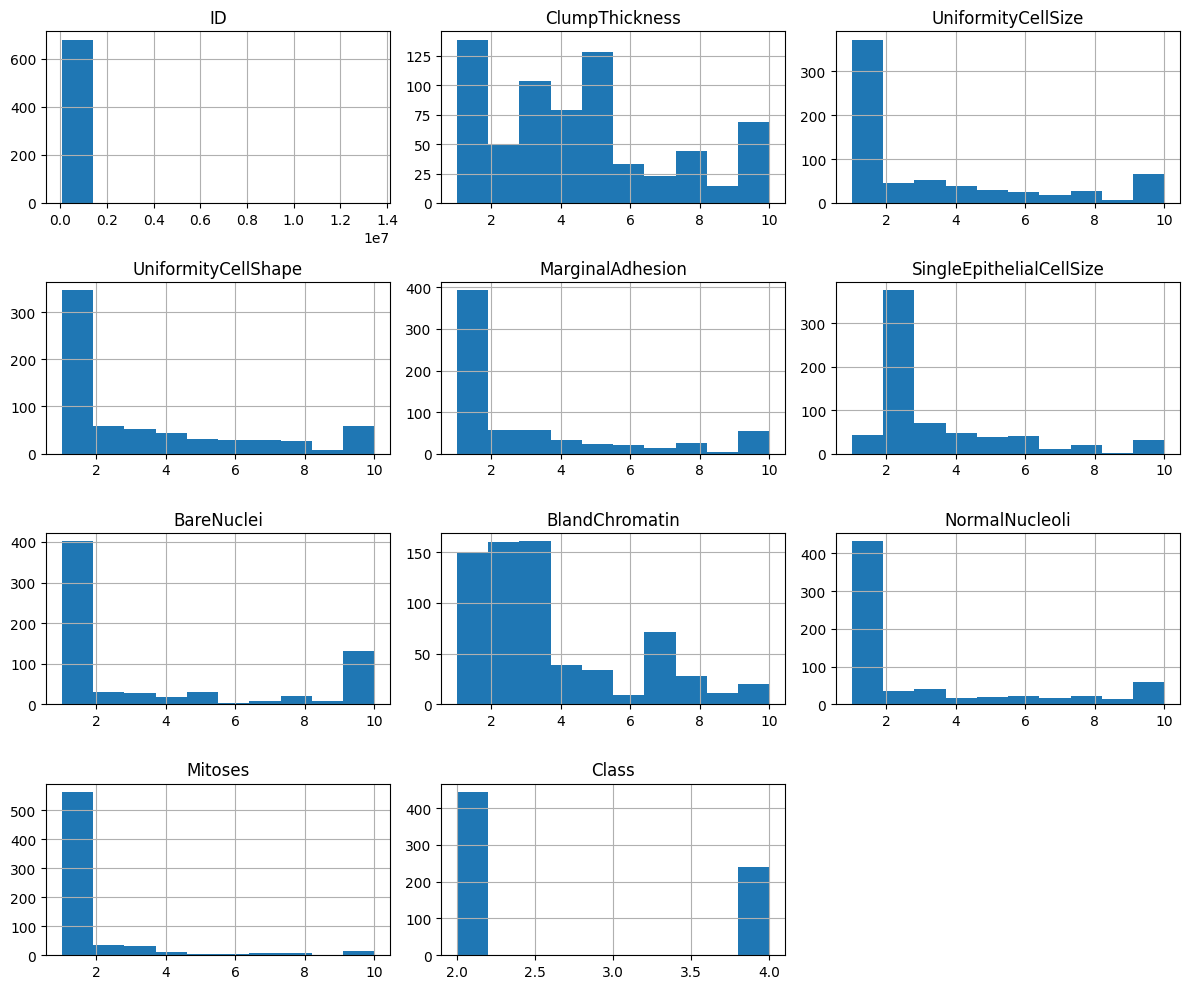

In [55]:
# Histograms
raw.hist(figsize=(12, 10))
plt.tight_layout(); plt.show()

As displayed in the histograms, features such as Mitoses, BareNuclei, UniformityCellSize, and UniformityCellShape have very right skewed histograms, implying low values heavily dominate and a normalization may be useful to increase model performance.

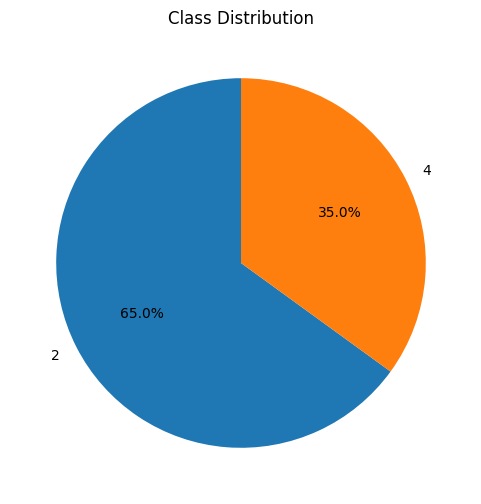

In [56]:
# Pie chart for class distribution
import matplotlib.pyplot as plt
class_counts = raw['Class'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Class Distribution')
plt.show()


The class imbalance can be seen on the pie chart where Class 1 consists of 35 out of 54 (65%), while Class 4 consists of the remaining 19 out of 54 (35 %) of the data, which can have an impact on the model’s performance and should be handled during training.

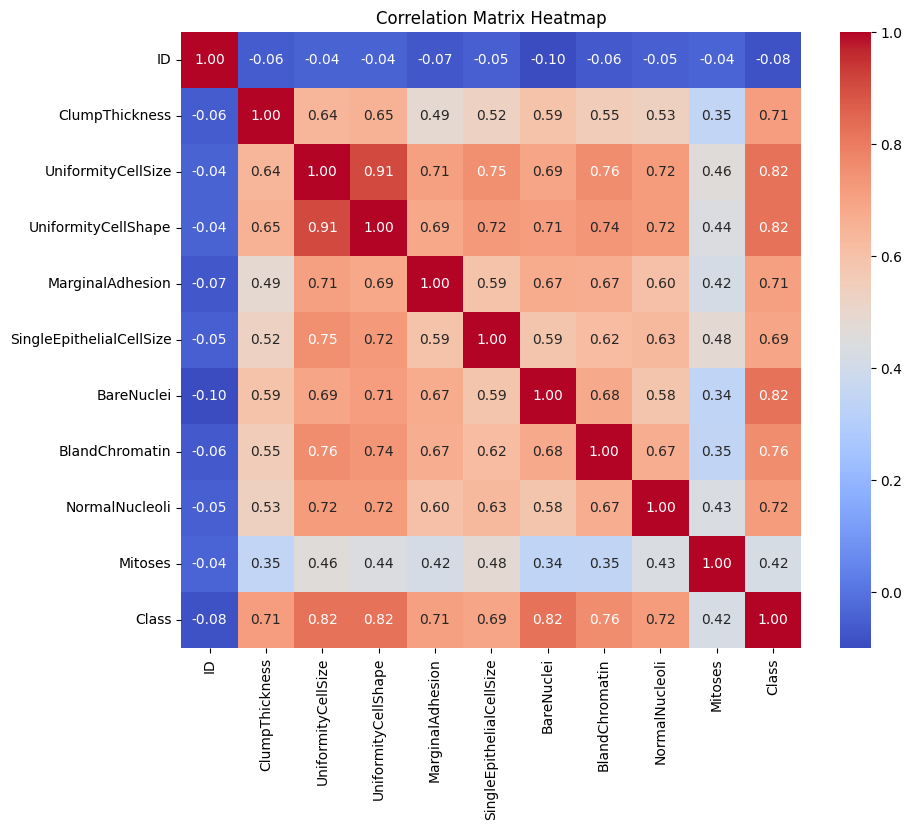

In [57]:
# correlation Matrix Heatmap
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(raw.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')
plt.show()


According to the heatmap, Uniformity of Cell Size, Cell Shape, and Bare Nuclei are the most correlated with the Class label and hence, would make critical features for classification.

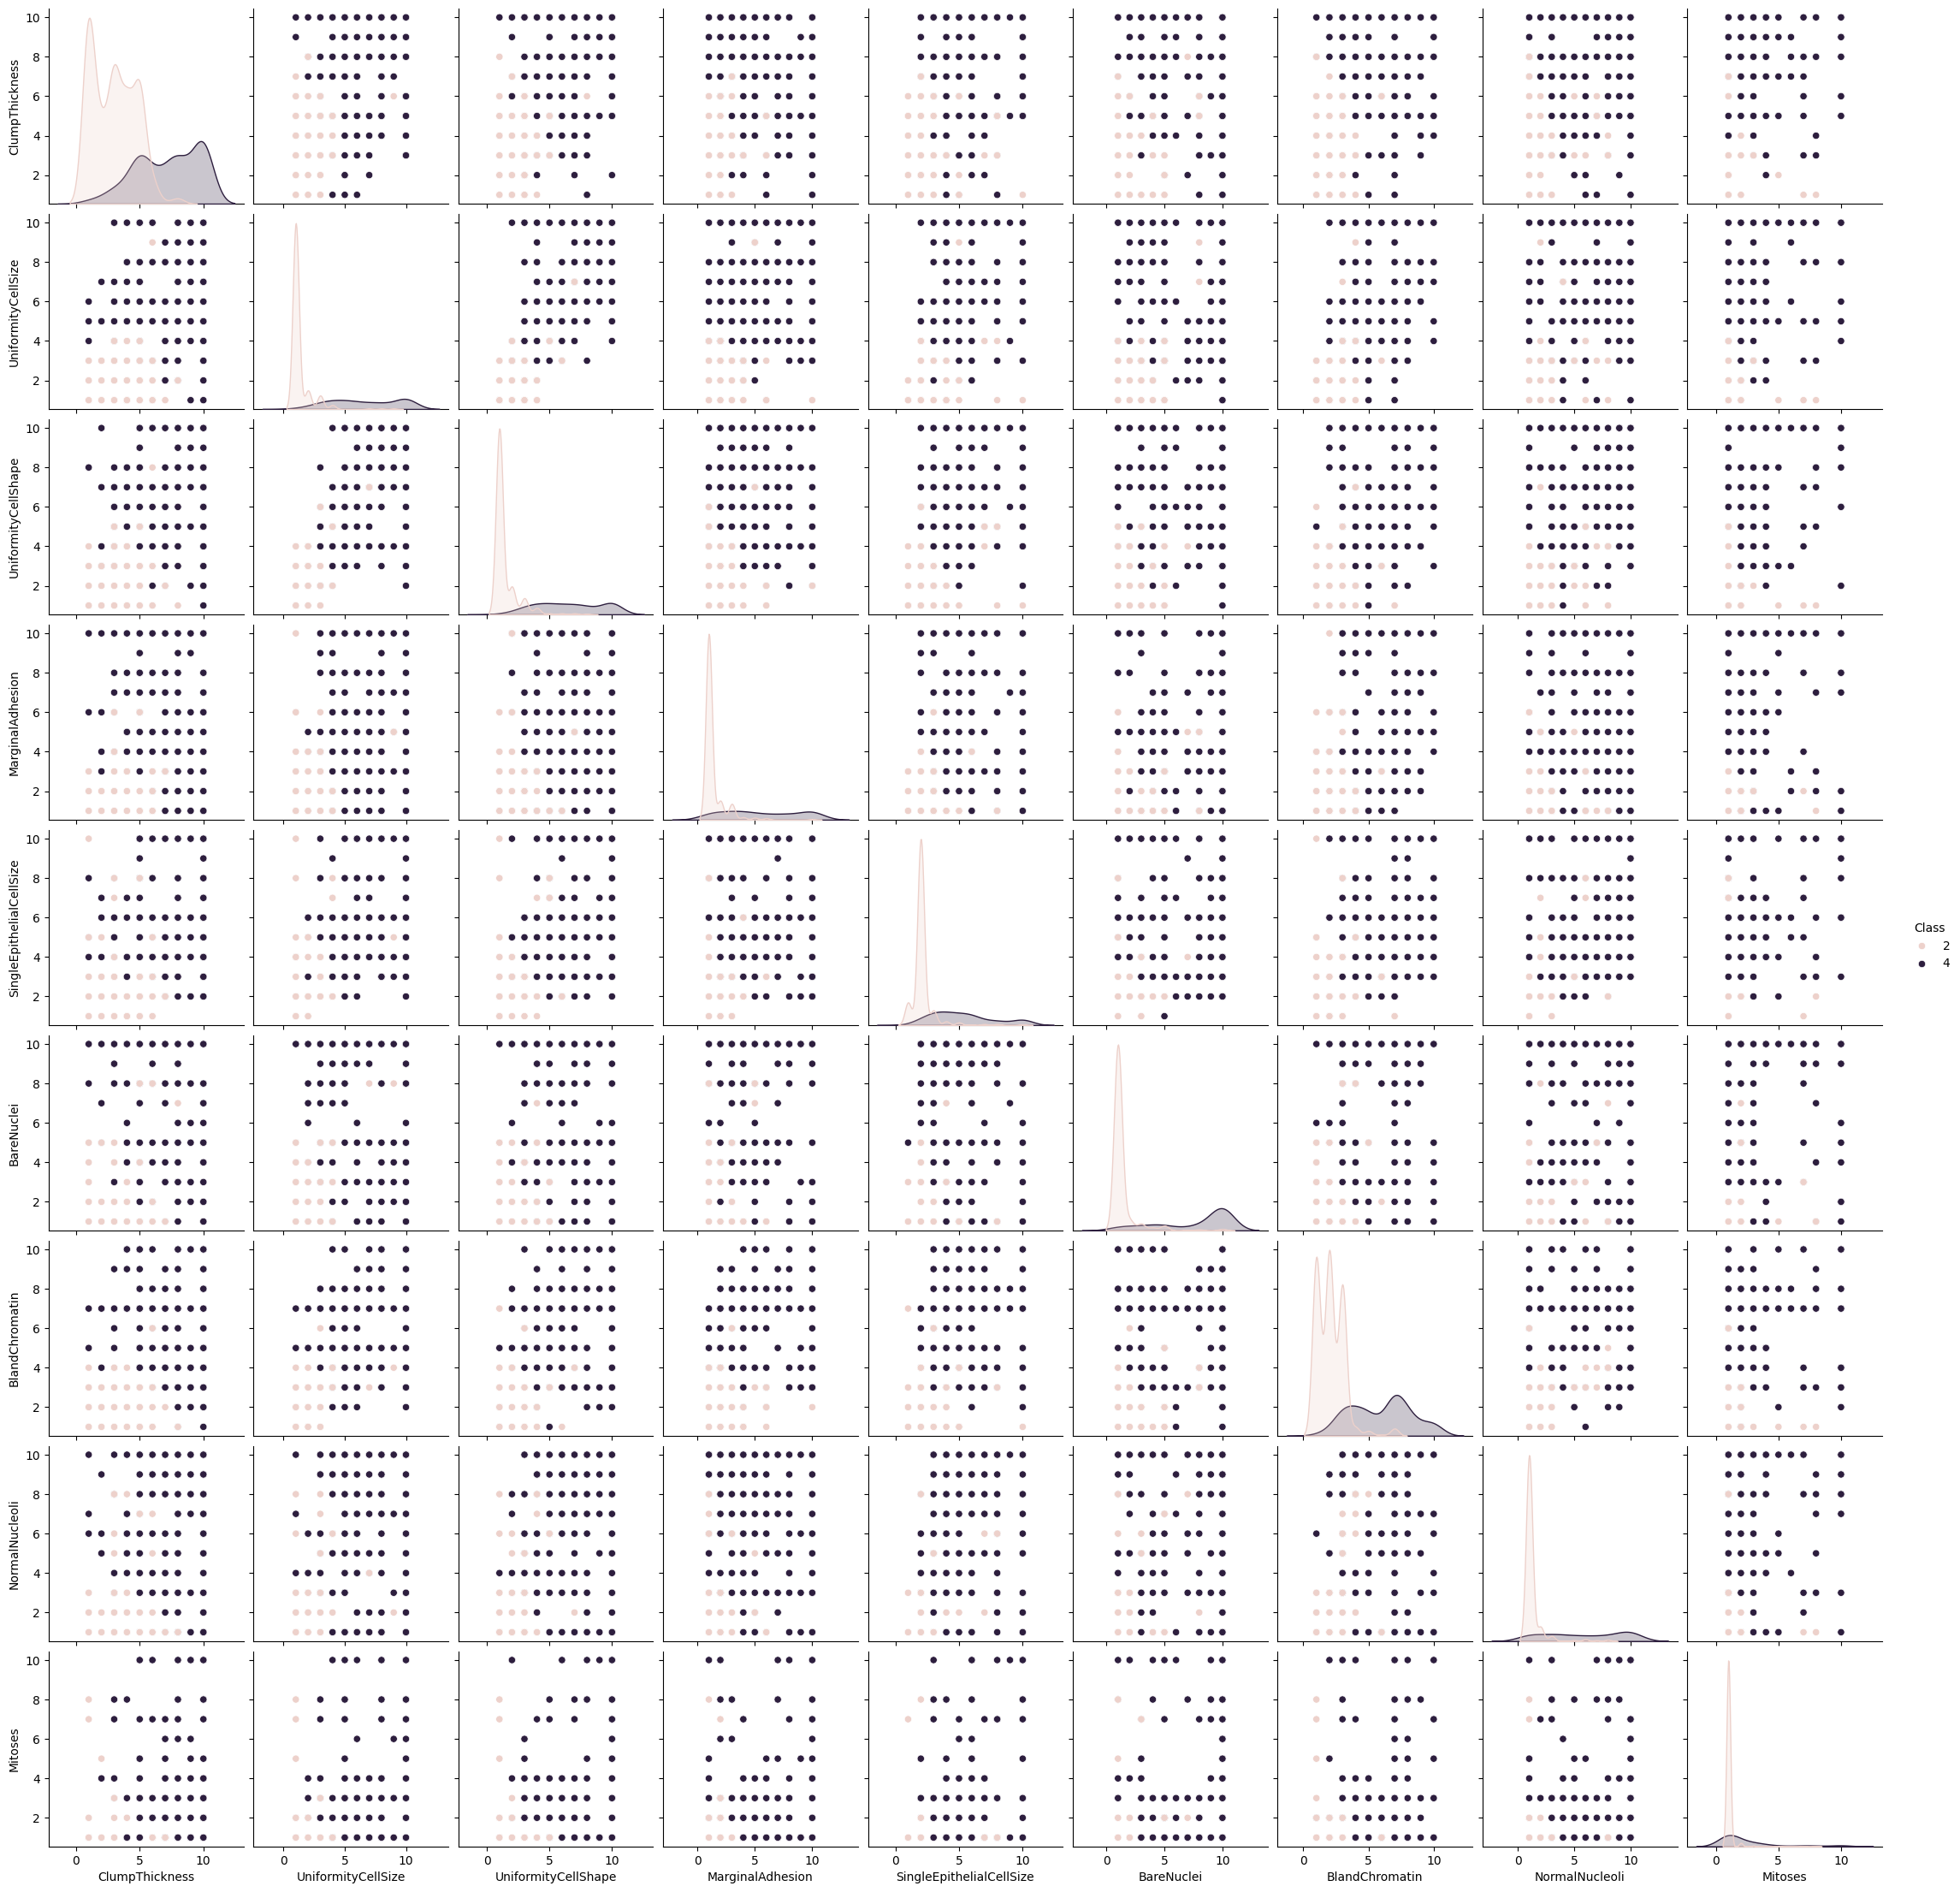

In [58]:
# pair plot

import matplotlib.pyplot as plt
sns.pairplot(raw, hue='Class', vars=column_names[1:-1])
plt.show()


In this pair plot, feature distributions and pairwise relationships by class are plotted in which clear clustering patterns and class separability can be observed in some combinations of features.

# Preprocessing

In [59]:
X = raw.drop(['ID', 'Class'], axis=1).values
y = (raw['Class'] == 4).astype(int).values  # malignant=4 → 1, benign=2 → 0

In [60]:
# Train/Test split
test_size = 0.10
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=y
)

In [61]:
# Scaling
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [62]:
# Convert to tensors
tensor_X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
tensor_y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

tensor_X_test = torch.tensor(X_test_scaled, dtype=torch.float32)
tensor_y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Model Definition (Logistic Regression: 30 features → 1 output)

In [63]:
class LogisticModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.linear(x))

model = LogisticModel(input_dim=X_train_scaled.shape[1])
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")  # should be ≤ 300

Total parameters: 10


# Training

In [64]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
epochs = 100
loss_history = []


In [65]:
for epoch in range(1, epochs+1):
    model.train()
    optimizer.zero_grad()
    outputs = model(tensor_X_train)
    loss = criterion(outputs, tensor_y_train)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/100, Loss: 0.4715
Epoch 20/100, Loss: 0.3150
Epoch 30/100, Loss: 0.2294
Epoch 40/100, Loss: 0.1818
Epoch 50/100, Loss: 0.1540
Epoch 60/100, Loss: 0.1365
Epoch 70/100, Loss: 0.1246
Epoch 80/100, Loss: 0.1162
Epoch 90/100, Loss: 0.1099
Epoch 100/100, Loss: 0.1050


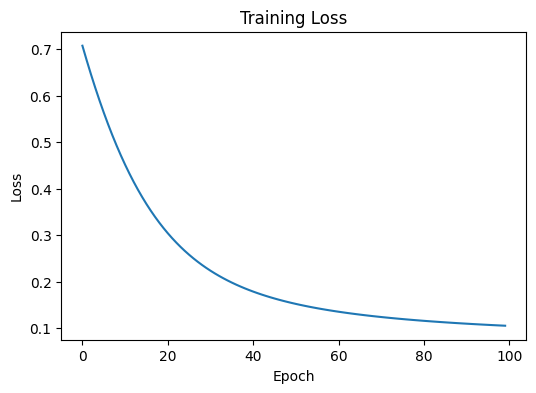

In [66]:
# Plot loss
to_plot = pd.Series(loss_history)
to_plot.plot(figsize=(6,4), xlabel='Epoch', ylabel='Loss', title='Training Loss'); plt.show()

Over the epochs, the training loss continuously decreases, which implies the successful learning and convergence of the model.

# Evaluation

In [67]:
model.eval()
with torch.no_grad():
    preds = model(tensor_X_test).round().numpy().astype(int)

cm = confusion_matrix(y_test, preds)
acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds)
rec = recall_score(y_test, preds)
f1 = f1_score(y_test, preds)

print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")

Confusion Matrix:
 [[43  2]
 [ 0 24]]
Accuracy: 0.9710
Precision: 0.9231
Recall: 1.0000
F1 Score: 0.9600


 Achieving ≥ 97% accuracy simply requires the use of a very simple logistic regression model

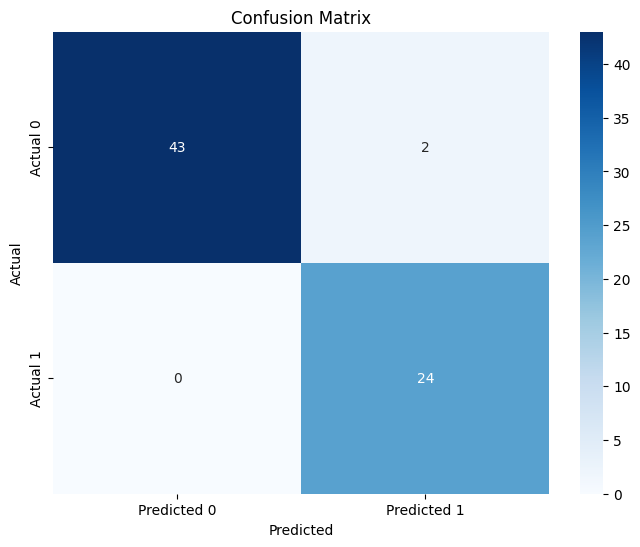

In [68]:
# confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
